<a href="https://colab.research.google.com/github/min207/ESAA/blob/main/%EB%AF%B8%EB%8B%88%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B82_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. 라이브러리/데이터 불러오기**

In [207]:
import numpy as np
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub_sample = pd.read_csv("submission_sample.csv")

In [208]:
train[train.bedCount.isnull()==True]

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
71,107,close,jeonbuk,26,19990805,NaN,traditional_hospital,4.131858e+09,1.436118e+08,3.529097e+09,...,2.658296e+09,2.632717e+09,2.442951e+09,2.557878e+07,0.000000e+00,2.487828e+09,0.000000e+00,85.0,74.0,same
193,281,close,gyeonggi,12,20121213,NaN,NaN,3.054388e+08,2.241614e+07,4.674753e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,15.0,15.0,change
297,423,close,choongnam,159,20140618,NaN,hospital,6.717144e+09,8.200000e+09,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,79.0,79.0,same
298,426,close,gyeongbuk,107,19830705,NaN,hospital,0.000000e+00,0.000000e+00,5.479428e+07,...,6.370097e+09,2.170973e+09,0.000000e+00,4.199124e+09,2.498749e+09,3.259161e+09,0.000000e+00,NaN,NaN,NaN
300,428,open,seoul,79,20011017,NaN,traditional_hospital,1.340971e+09,8.108450e+08,5.043409e+08,...,5.349000e+09,3.123072e+09,0.000000e+00,2.225928e+09,2.190000e+09,5.536178e+09,6.269440e+09,15.0,15.0,same


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f31144e46d0>,
      dtype=object)

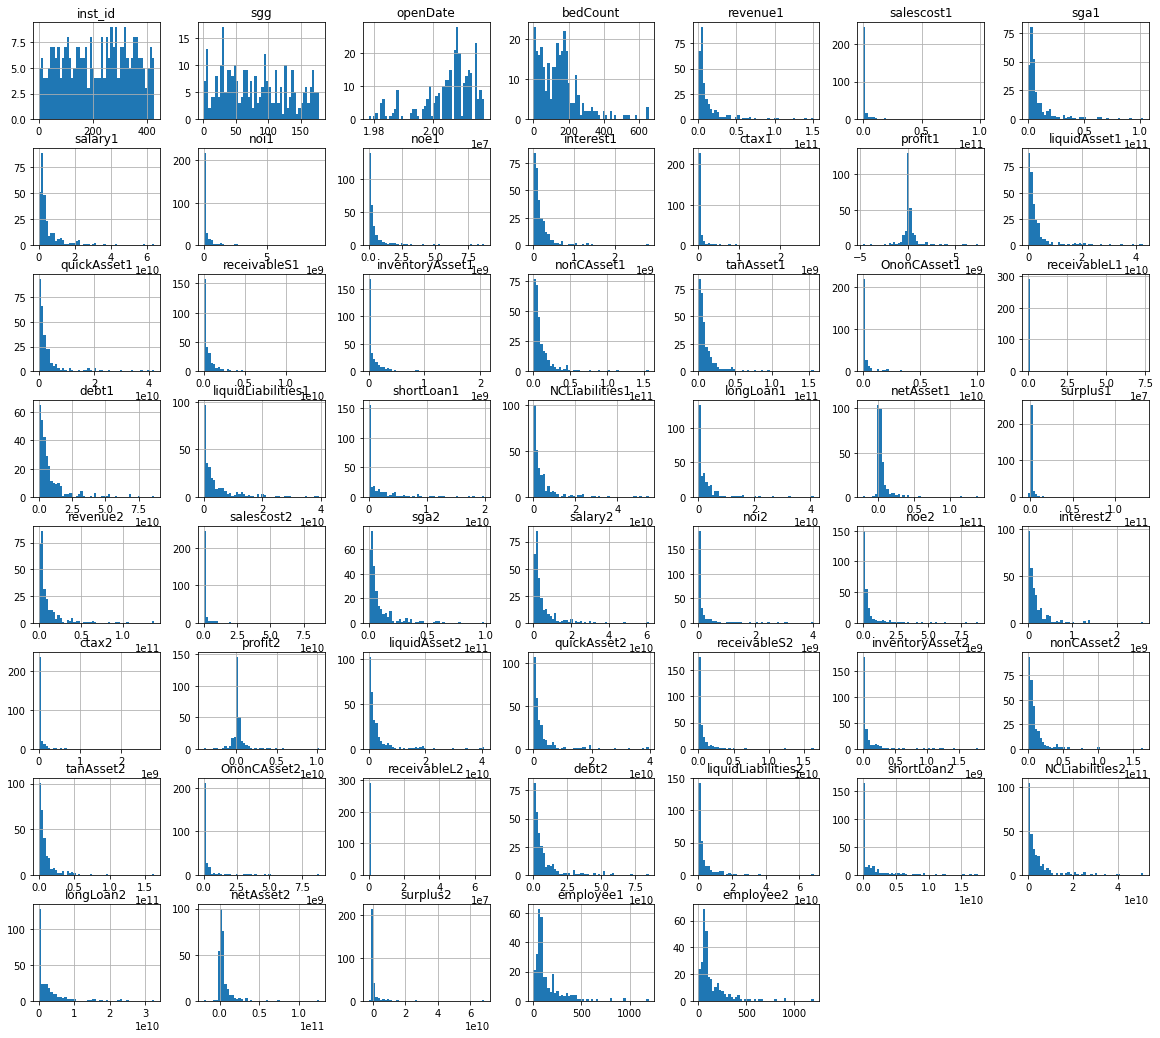

In [209]:
train.hist(bins=50, figsize=(20,18))

> 대부분의 숫자형 변수는 한쪽으로 치우친 분포를 가지고 있음 > 로그 변환

## **2. 파생 변수 생성**

In [210]:
# 2016 > 2017에서 이익, 부채, 수익, 이자비용, 유동자산, 급여, 직원 수 변화를 나타내는 변수 생성 
train['profit'] = train.profit1 - train.profit2
train['debt'] = train.debt1 - train.debt2
train['revenue'] = train.revenue1- train.revenue2
train['interest'] = train.interest1 - train.interest2
train['liquidAsset'] = train.liquidAsset1 - train.liquidAsset2
train['salary'] = train.salary1 - train.salary2
train['employee'] = train.employee1 - train.employee2
train['netAsset'] = train.netAsset1 - train.netAsset2

## **3. 간단한 전처리 - 대부분 결측치인 행 제거, 로그 변환**

In [211]:
# train 데이터 세트 opendate 변수 datetime 변환
train["openDate"] = pd.to_datetime(train["openDate"].astype("str"), format="%Y/%m/%d")

# 연속형 데이터 제외 object 타입으로 변환
train.inst_id = train.inst_id.astype(object)
train.sgg = train.sgg.astype(object)

In [212]:
nan_id = train[train.revenue1.isnull()==True].index
list(nan_id)
train_1 = train.drop(nan_id)    # 총 8개의 행 삭제
train_1['OC'] = train['OC'].map({' close':0, 'open':1})     # close: 0, open: 1로 변환

In [213]:
train_1.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,employee2,ownerChange,profit,debt,revenue,interest,liquidAsset,salary,employee,netAsset
0,1,1,choongnam,73,2007-12-28,175.0,nursing_hospital,4.217530e+09,0.000000e+00,3.961135e+09,...,64.0,same,17339993.0,-7.616775e+07,-8.031824e+07,-2446810.0,1.825302e+08,-2.995207e+07,-2.0,225169678.0
2,4,1,gyeonggi,89,2016-12-28,468.0,nursing_hospital,1.004522e+09,5.154837e+08,4.472197e+08,...,1.0,same,41864754.0,9.241434e+07,1.004522e+09,0.0,2.724421e+08,2.964023e+08,233.0,300508824.0
3,7,1,incheon,141,2000-08-14,353.0,general_hospital,7.250734e+10,0.000000e+00,7.067740e+10,...,663.0,same,64442822.0,4.608787e+09,5.649006e+09,-80540715.0,1.915823e+09,2.074703e+09,0.0,902830288.0
4,9,1,gyeongnam,32,2005-09-01,196.0,general_hospital,4.904354e+10,0.000000e+00,4.765605e+10,...,197.0,same,48107111.0,-1.534487e+09,9.607370e+08,-42602315.0,1.410308e+09,1.000740e+09,9.0,80749696.0
5,11,1,gyeongnam,155,2002-05-01,243.0,general_hospital,3.358054e+10,9.222997e+09,2.372791e+10,...,390.0,same,-120913329.0,0.000000e+00,-7.539098e+08,-79048185.0,7.656857e+08,2.674107e+08,7.0,0.0


In [214]:
train_1[train_1.bedCount.isnull()==True].instkind

71     traditional_hospital
193                     NaN
297                hospital
298                hospital
300    traditional_hospital
Name: instkind, dtype: object

In [215]:
train_1[(train_1.employee1<20) & (train_1.employee2<20) & (train_1.employee1>1)].bedCount.mean()

14.4

In [216]:
train_1[train_1.instkind=='traditional_hospital'].bedCount.mean()

46.666666666666664

In [217]:
train_1[train_1.instkind=='hospital'].bedCount.mean()

96.22093023255815

In [218]:
# bedCount, instkind와 연결시켜서 결측치 처리
train_1.loc[[71,300],'bedCount'] = 47
train_1.loc[[297,298],'bedCount'] = 96
train_1.loc[193,'bedCount'] = 14

In [219]:
# object 타입, 음수 값을 포함하는 변수 제거
train_2 = train_1.copy()
train_2.drop(['inst_id','OC','sido','sgg','openDate','instkind','bedCount','ownerChange','profit','debt','revenue','interest',
              'liquidAsset','salary','employee','profit1','profit2','netAsset','netAsset1','netAsset2'], axis=1, inplace=True)

In [220]:
train_2 = np.log1p(train_2)

In [221]:
train_2.insert(0,'inst_id',train_1.inst_id)
train_2.insert(1,'OC',train_1.OC)
train_2.insert(2,'sido',train_1.sido)
train_2.insert(3,'sgg',train_1.sgg)
train_2.insert(4,'openDate',train_1.openDate)
train_2.insert(5,'bedCount',train_1.bedCount)
train_2.insert(6,'instkind',train_1.instkind)
train_2.insert(15,'profit1',train_1.profit1)
train_2.insert(39,'profit2',train_1.profit2)
train_2.insert(29,'netAsset1',train_1.netAsset1)
train_2.insert(53,'netAsset2',train_1.netAsset2)
train_2.insert(57,'ownerChange',train_1.ownerChange)
train_2.insert(58,'profit',train_1.profit)
train_2.insert(59,'degt',train_1.debt)
train_2.insert(60,'revenue',train_1.revenue)
train_2.insert(61,'interest',train_1.interest)
train_2.insert(62,'liquidAsset',train_1.liquidAsset)
train_2.insert(63,'salary',train_1.salary)
train_2.insert(64,'employee',train_1.employee)
train_2.insert(65,'netAsset',train_1.netAsset)

In [222]:
train_2.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,employee2,ownerChange,profit,degt,revenue,interest,liquidAsset,salary,employee,netAsset
0,1,1,choongnam,73,2007-12-28,175.0,nursing_hospital,22.162515,0.000000,22.099796,...,4.174387,same,17339993.0,-7.616775e+07,-8.031824e+07,-2446810.0,1.825302e+08,-2.995207e+07,-2.0,225169678.0
2,4,1,gyeonggi,89,2016-12-28,468.0,nursing_hospital,20.727778,20.060616,19.918561,...,0.693147,same,41864754.0,9.241434e+07,1.004522e+09,0.0,2.724421e+08,2.964023e+08,233.0,300508824.0
3,7,1,incheon,141,2000-08-14,353.0,general_hospital,25.006954,0.000000,24.981392,...,6.498282,same,64442822.0,4.608787e+09,5.649006e+09,-80540715.0,1.915823e+09,2.074703e+09,0.0,902830288.0
4,9,1,gyeongnam,32,2005-09-01,196.0,general_hospital,24.615974,0.000000,24.587275,...,5.288267,same,48107111.0,-1.534487e+09,9.607370e+08,-42602315.0,1.410308e+09,1.000740e+09,9.0,80749696.0
5,11,1,gyeongnam,155,2002-05-01,243.0,general_hospital,24.237212,22.944966,23.889918,...,5.968708,same,-120913329.0,0.000000e+00,-7.539098e+08,-79048185.0,7.656857e+08,2.674107e+08,7.0,0.0


In [223]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 300
Data columns (total 66 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   inst_id             293 non-null    object        
 1   OC                  293 non-null    int64         
 2   sido                293 non-null    object        
 3   sgg                 293 non-null    object        
 4   openDate            293 non-null    datetime64[ns]
 5   bedCount            293 non-null    float64       
 6   instkind            292 non-null    object        
 7   revenue1            293 non-null    float64       
 8   salescost1          293 non-null    float64       
 9   sga1                293 non-null    float64       
 10  salary1             293 non-null    float64       
 11  noi1                293 non-null    float64       
 12  noe1                293 non-null    float64       
 13  interest1           293 non-null    float64       

In [225]:
# 나머지는 -999로 결측치 처리
train_2.employee1 = train_2.employee1.fillna(-999)
train_2.employee2 = train_2.employee2.fillna(-999)
train_2.employee = train_2.employee.fillna(0)

In [226]:
# train_3  = train_2.drop(['inst_id','sido','sgg','ownerChange','instkind','openDate'], axis=1)
train_3 = train_2.drop(['inst_id','openDate','sgg'], axis=1)
train_3 = pd.get_dummies(train_3, columns = ['sido', 'ownerChange','instkind'])

In [227]:
train_3.head()

,OC,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,...,sido_ulsan,ownerChange_change,ownerChange_same,instkind_clinic,instkind_dental_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital
0,1,175.0,22.162515,0.000000,22.099796,21.433189,16.566138,16.539187,16.398469,17.269990,...,0,0,1,0,0,0,0,1,0,0
2,1,468.0,20.727778,20.060616,19.918561,19.507228,11.240552,10.308986,0.000000,0.000000,...,0,0,1,0,0,0,0,1,0,0
3,1,353.0,25.006954,0.000000,24.981392,24.182293,20.042488,20.954034,20.902985,18.973242,...,0,0,1,0,0,1,0,0,0,0
4,1,196.0,24.615974,0.000000,24.587275,23.920337,18.537150,21.073281,20.991191,0.000000,...,0,0,1,0,0,1,0,0,0,0
5,1,243.0,24.237212,22.944966,23.889918,23.535996,17.996252,20.423875,19.633997,0.000000,...,0,0,1,0,0,1,0,0,0,0


## **4. 피처 중요도 시각화**

In [228]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [229]:
# train/ valid 데이터 분할
X = train_3.drop('OC', axis=1)
y = train_3.OC

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=100)

In [232]:
train_cnt = y_train.count()
test_cnt = y_valid.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_valid.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_valid.value_counts()/test_cnt)

학습 세트 Shape:(205, 84), 테스트 세트 Shape:(88, 84)
 학습 세트 레이블 값 분포 비율
1    0.95122
0    0.04878
Name: OC, dtype: float64

 테스트 세트 레이블 값 분포 비율
1    0.943182
0    0.056818
Name: OC, dtype: float64


In [233]:
xgb_model = XGBClassifier(n_estimators=500)

params = {'max_depth':[4,6,8,10],
          'min_child_weight':[0.5,1,1.5],
          'subsample':[0.6, 0.8, 1],
          'gamma':[0,0.05,0.1,0.15,0.2]}

gridcv = GridSearchCV(xgb_model, param_grid=params, cv=3, scoring="accuracy")

gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='error',
           eval_set=[(X_train, y_train), (X_valid, y_valid)])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

[0]	validation_0-error:0.04878	validation_1-error:0.056818
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.04878	validation_1-error:0.056818
[2]	validation_0-error:0.04878	validation_1-error:0.056818
[3]	validation_0-error:0.04878	validation_1-error:0.056818
[4]	validation_0-error:0.04878	validation_1-error:0.056818
[5]	validation_0-error:0.04878	validation_1-error:0.056818
[6]	validation_0-error:0.04878	validation_1-error:0.056818
[7]	validation_0-error:0.04878	validation_1-error:0.056818
[8]	validation_0-error:0.04878	validation_1-error:0.056818
[9]	validation_0-error:0.04878	validation_1-error:0.056818
[10]	validation_0-error:0.04878	validation_1-error:0.056818
[11]	validation_0-error:0.04878	validation_1-error:0.056818
[12]	validation_0-error:0.04878	validation_1-error:0.056818
[13]	validation_0-error:0.04878	

GridSearchCV(cv=3, estimator=XGBClassifier(n_estimators=500),
             param_grid={'gamma': [0, 0.05, 0.1, 0.15, 0.2],
                         'max_depth': [4, 6, 8, 10],
                         'min_child_weight': [0.5, 1, 1.5],
                         'subsample': [0.6, 0.8, 1]},
             scoring='accuracy')

In [122]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [234]:
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
xgb_acc_score = accuracy_score(y_valid, gridcv.predict(X_valid))
print('acc AUC: {0:.4f}'.format(xgb_acc_score))

GridSearchCV 최적 파라미터: {'gamma': 0, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6}
acc AUC: 0.9545


In [235]:
xgb_clf = XGBClassifier(max_depth=4, min_child_weight=1, subsample=0.6)

evals = [(X_valid, y_valid)]
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="error", eval_set=evals,
                verbose=True)

xgb_clf_acc_score = accuracy_score(y_valid, xgb_clf.predict(X_valid))
print('accuacy: {0:.4f}'.format(xgb_clf_acc_score))

[0]	validation_0-error:0.056818
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.045455
[2]	validation_0-error:0.045455
[3]	validation_0-error:0.056818
[4]	validation_0-error:0.056818
[5]	validation_0-error:0.056818
[6]	validation_0-error:0.056818
[7]	validation_0-error:0.056818
[8]	validation_0-error:0.056818
[9]	validation_0-error:0.056818
[10]	validation_0-error:0.056818
[11]	validation_0-error:0.056818
[12]	validation_0-error:0.056818
[13]	validation_0-error:0.056818
[14]	validation_0-error:0.056818
[15]	validation_0-error:0.056818
[16]	validation_0-error:0.056818
[17]	validation_0-error:0.056818
[18]	validation_0-error:0.056818
[19]	validation_0-error:0.056818
[20]	validation_0-error:0.056818
[21]	validation_0-error:0.056818
[22]	validation_0-error:0.056818
[23]	validation_0-error:0.056818
[24]	validation_0-error:0.056818
[25]	validation_0-error:0.056818
[26]	validation_0-error:0.056818
[27]	validation_0-error:0.056818
[28]	validation_0-e

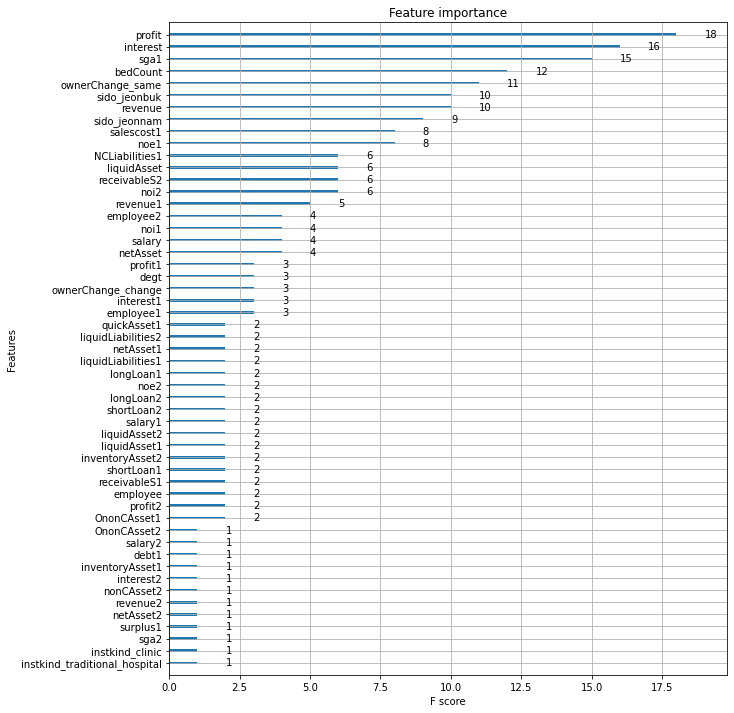

In [236]:
import matplotlib.pyplot as plt
%matplotlib inline

fit,ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_clf, ax=ax)

> - 병원의 규모와 관련 있어 보이는 bedCount, employee가 큰 영향을 끼침 
- 병원의 재무정보 중에서는 interest, profit, debt, revenue 사용
- 그 외에 ownerchange, salary 사용

## **5. XGBoost**

In [237]:
train_4 = train_2.drop(['inst_id', 'sgg','sido','instkind', 'openDate', 'salescost1', 'sga1', 'noi1', 'noe1',
                        'ctax1', 'liquidAsset1', 'quickAsset1', 'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1',
                        'OnonCAsset1', 'receivableL1', 'liquidLiabilities1','shortLoan1', 'NCLiabilities1', 'longLoan1',
                        'surplus1','salescost2', 'sga2', 'noi2', 'noe2','ctax2', 'liquidAsset2', 'netAsset1','netAsset2','netAsset',
                        'quickAsset2','receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2','OnonCAsset2', 'receivableL2', 
                        'liquidLiabilities2','shortLoan2', 'NCLiabilities2', 'longLoan2', 'surplus2','liquidAsset'], axis=1)
train_4 = pd.get_dummies(train_4, columns = ['ownerChange'])
train_4.head()

,OC,bedCount,revenue1,salary1,interest1,profit1,debt1,revenue2,salary2,interest2,...,employee1,employee2,profit,degt,revenue,interest,salary,employee,ownerChange_change,ownerChange_same
0,1,175.0,22.162515,21.433189,16.398469,225169678.0,20.341751,22.181380,21.447809,16.568091,...,4.143135,4.174387,17339993.0,-7.616775e+07,-8.031824e+07,-2446810.0,-2.995207e+07,-2.0,0,1
2,1,468.0,20.727778,19.507228,0.000000,41864754.0,18.341793,0.000000,0.000000,0.000000,...,5.459586,0.693147,41864754.0,9.241434e+07,1.004522e+09,0.0,2.964023e+08,233.0,0,1
3,1,353.0,25.006954,24.182293,20.902985,902830288.0,24.469560,24.925842,24.114795,20.968110,...,6.498282,6.498282,64442822.0,4.608787e+09,5.649006e+09,-80540715.0,2.074703e+09,0.0,0,1
4,1,196.0,24.615974,23.920337,20.991191,80749696.0,24.633249,24.596190,23.878565,21.023260,...,5.332719,5.288267,48107111.0,-1.534487e+09,9.607370e+08,-42602315.0,1.000740e+09,9.0,0,1
5,1,243.0,24.237212,23.535996,19.633997,-46227375.0,0.000000,24.259415,23.519810,19.845018,...,5.986452,5.968708,-120913329.0,0.000000e+00,-7.539098e+08,-79048185.0,2.674107e+08,7.0,0,1


In [238]:
train_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 300
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OC                  293 non-null    int64  
 1   bedCount            293 non-null    float64
 2   revenue1            293 non-null    float64
 3   salary1             293 non-null    float64
 4   interest1           293 non-null    float64
 5   profit1             293 non-null    float64
 6   debt1               293 non-null    float64
 7   revenue2            293 non-null    float64
 8   salary2             293 non-null    float64
 9   interest2           293 non-null    float64
 10  profit2             293 non-null    float64
 11  debt2               293 non-null    float64
 12  employee1           293 non-null    float64
 13  employee2           293 non-null    float64
 14  profit              293 non-null    float64
 15  degt                293 non-null    float64
 16  revenue 

In [239]:
X4 = train_4.drop('OC', axis=1)
y4 = train_4.OC

X4_train, X4_valid, y4_train, y4_valid = train_test_split(X4, y4, test_size=0.2, random_state=0)

In [240]:
xgb_model2 = XGBClassifier(n_estimators=500)

params = {'max_depth':[4,6,8,10],
          'min_child_weight':[0.5,1,1.5],
          'subsample':[0.6, 0.8, 1],
          'gamma':[0,0.05,0.1,0.15,0.2]}

gridcv2 = GridSearchCV(xgb_model2, param_grid=params, cv=3)

gridcv2.fit(X4_train, y4_train, early_stopping_rounds=30, eval_metric="error",
           eval_set=[(X4_train, y4_train), (X4_valid, y4_valid)])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[11]	validation_0-error:0.038462	validation_1-error:0.050847
[12]	validation_0-error:0.038462	validation_1-error:0.050847
[13]	validation_0-error:0.034188	validation_1-error:0.050847
[14]	validation_0-error:0.029915	validation_1-error:0.050847
[15]	validation_0-error:0.029915	validation_1-error:0.050847
[16]	validation_0-error:0.029915	validation_1-error:0.050847
[17]	validation_0-error:0.029915	validation_1-error:0.050847
[18]	validation_0-error:0.029915	validation_1-error:0.050847
[19]	validation_0-error:0.029915	validation_1-error:0.050847
[20]	validation_0-error:0.029915	validation_1-error:0.050847
[21]	validation_0-error:0.029915	validation_1-error:0.050847
[22]	validation_0-error:0.029915	validation_1-error:0.050847
[23]	validation_0-error:0.029915	validation_1-error:0.050847
[24]	validation_0-error:0.029915	validation_1-error:0.050847
[25]	validation_0-error:0.029915	validation_1-error:0.050847
[26]	validation_0-error:0.029915	validation_1-err

GridSearchCV(cv=3, estimator=XGBClassifier(n_estimators=500),
             param_grid={'gamma': [0, 0.05, 0.1, 0.15, 0.2],
                         'max_depth': [4, 6, 8, 10],
                         'min_child_weight': [0.5, 1, 1.5],
                         'subsample': [0.6, 0.8, 1]})

In [241]:
print('GridSearchCV 최적 파라미터:', gridcv2.best_params_)

GridSearchCV 최적 파라미터: {'gamma': 0.15, 'max_depth': 4, 'min_child_weight': 0.5, 'subsample': 0.6}


In [242]:
xgb = XGBClassifier(gamma = 0.15, max_depth = 4, min_child_weight = 0.5, subsample = 0.6)

evals = [(X4_valid, y4_valid)]
xgb.fit(X4_train, y4_train, early_stopping_rounds=100, eval_metric="error", eval_set=evals,
                verbose=True)

xgb_acc_score4 = accuracy_score(y4_valid, xgb.predict(X4_valid))
print('accuacy: {0:.4f}'.format(xgb_acc_score4))

[0]	validation_0-error:0.067797
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.067797
[2]	validation_0-error:0.067797
[3]	validation_0-error:0.050847
[4]	validation_0-error:0.033898
[5]	validation_0-error:0.033898
[6]	validation_0-error:0.033898
[7]	validation_0-error:0.033898
[8]	validation_0-error:0.033898
[9]	validation_0-error:0.033898
[10]	validation_0-error:0.050847
[11]	validation_0-error:0.033898
[12]	validation_0-error:0.050847
[13]	validation_0-error:0.050847
[14]	validation_0-error:0.033898
[15]	validation_0-error:0.033898
[16]	validation_0-error:0.033898
[17]	validation_0-error:0.050847
[18]	validation_0-error:0.033898
[19]	validation_0-error:0.033898
[20]	validation_0-error:0.033898
[21]	validation_0-error:0.033898
[22]	validation_0-error:0.033898
[23]	validation_0-error:0.033898
[24]	validation_0-error:0.050847
[25]	validation_0-error:0.050847
[26]	validation_0-error:0.050847
[27]	validation_0-error:0.050847
[28]	validation_0-e

## **6. SMOTE 오버 샘플링**

In [244]:
train_5 = train_4.copy()

In [245]:
train_5.isnull().sum()

OC                    0
bedCount              0
revenue1              0
salary1               0
interest1             0
profit1               0
debt1                 0
revenue2              0
salary2               0
interest2             0
profit2               0
debt2                 0
employee1             0
employee2             0
profit                0
degt                  0
revenue               0
interest              0
salary                0
employee              0
ownerChange_change    0
ownerChange_same      0
dtype: int64

In [246]:
X5 = train_5.drop('OC', axis=1)
y5 = train_5.OC

X5_train, X5_valid, y5_train, y5_valid = train_test_split(X5, y5, test_size=0.2, random_state=100)

In [247]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X5_train, y5_train)
print(pd.Series(y_train_over).value_counts())

1    222
0    222
Name: OC, dtype: int64


In [248]:
xgb2 = XGBClassifier(n_estimators=500)

gridcv5 = GridSearchCV(xgb2, param_grid=params, cv=3)

gridcv5.fit(X_train_over, y_train_over, early_stopping_rounds=30, eval_metric="error",
           eval_set=[(X_train_over, y_train_over), (X5_valid, y5_valid)])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[45]	validation_0-error:0.009009	validation_1-error:0.152542
[46]	validation_0-error:0.009009	validation_1-error:0.152542
[47]	validation_0-error:0.009009	validation_1-error:0.152542
Stopping. Best iteration:
[17]	validation_0-error:0.02027	validation_1-error:0.118644

[0]	validation_0-error:0.047297	validation_1-error:0.20339
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.033784	validation_1-error:0.169492
[2]	validation_0-error:0.036036	validation_1-error:0.152542
[3]	validation_0-error:0.022523	validation_1-error:0.186441
[4]	validation_0-error:0.029279	validation_1-error:0.135593
[5]	validation_0-error:0.02027	validation_1-error:0.186441
[6]	validation_0-error:0.018018	validation_1-error:0.135593
[7]	validation_0-error:0.022523	validation_1-error:0.152542
[8]	validation_0-error:0.018018	validation_1-error:0.13

GridSearchCV(cv=3, estimator=XGBClassifier(n_estimators=500),
             param_grid={'gamma': [0, 0.05, 0.1, 0.15, 0.2],
                         'max_depth': [4, 6, 8, 10],
                         'min_child_weight': [0.5, 1, 1.5],
                         'subsample': [0.6, 0.8, 1]})

In [249]:
print('GridSearchCV 최적 파라미터:', gridcv5.best_params_)

GridSearchCV 최적 파라미터: {'gamma': 0, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1}


In [250]:
xgb3 = XGBClassifier(gamma=0, max_depth=4, min_child_weight=1, subsample=1)

evals = [(X5_valid, y5_valid)]
xgb3.fit(X_train_over, y_train_over, early_stopping_rounds=100, eval_metric="error", eval_set=evals,
                verbose=True)

xgb_acc_score5 = accuracy_score(y5_valid, xgb3.predict(X5_valid))
print('accuacy: {0:.4f}'.format(xgb_acc_score5))

[0]	validation_0-error:0.169492
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.152542
[2]	validation_0-error:0.169492
[3]	validation_0-error:0.135593
[4]	validation_0-error:0.135593
[5]	validation_0-error:0.135593
[6]	validation_0-error:0.135593
[7]	validation_0-error:0.135593
[8]	validation_0-error:0.152542
[9]	validation_0-error:0.152542
[10]	validation_0-error:0.152542
[11]	validation_0-error:0.152542
[12]	validation_0-error:0.152542
[13]	validation_0-error:0.152542
[14]	validation_0-error:0.152542
[15]	validation_0-error:0.152542
[16]	validation_0-error:0.152542
[17]	validation_0-error:0.135593
[18]	validation_0-error:0.135593
[19]	validation_0-error:0.135593
[20]	validation_0-error:0.152542
[21]	validation_0-error:0.135593
[22]	validation_0-error:0.135593
[23]	validation_0-error:0.135593
[24]	validation_0-error:0.135593
[25]	validation_0-error:0.135593
[26]	validation_0-error:0.135593
[27]	validation_0-error:0.135593
[28]	validation_0-e

> - 정확도 감소... 어캄 망했네~ 머리 터지겠다


---------------------------------------------------------
## **7. test 데이터 전처리**

In [252]:
test['employee1']=test['employee1'].astype('str').str.replace(",","").astype('float')
test['employee2']=test['employee2'].astype('str').str.replace(",","").astype('float')

test['profit'] = test.profit1 - test.profit2
test['degt'] = test.debt1 - test.debt2
test['revenue'] = test.revenue1 - test.revenue2
test['interest'] = test.interest1 - test.interest2
test['employee'] = test.employee1 - test.employee2
test['salary'] = test.salary1 - test.salary2

In [253]:
test2 = test.copy()

In [254]:
test2['revenue1'] = np.log1p(test2['revenue1'])
test2['employee1'] = np.log1p(test2['employee1'])
test2['interest1'] = np.log1p(test2['interest1'])
test2['debt1'] = np.log1p(test2['debt1'])
test2['salary1'] = np.log1p(test2['salary1'])
test2['revenue2'] = np.log1p(test2['revenue2'])
test2['employee2'] = np.log1p(test2['employee2'])
test2['interest2'] = np.log1p(test2['interest2'])
test2['debt2'] = np.log1p(test2['debt2'])
test2['salary2'] = np.log1p(test2['salary2'])

test_proto = test2[['bedCount', 'revenue1','salary1','interest1', 'profit1', 'debt1', 'revenue2','salary2','interest2', 'profit2',
       'debt2', 'employee1', 'employee2','profit', 'degt','revenue', 'interest','salary',
       'employee', 'ownerChange']]

test_proto = pd.get_dummies(test_proto, columns = ['ownerChange'])

test_proto.head()

,bedCount,revenue1,salary1,interest1,profit1,debt1,revenue2,salary2,interest2,profit2,...,employee1,employee2,profit,degt,revenue,interest,salary,employee,ownerChange_change,ownerChange_same
0,300.0,24.925341,24.196379,21.297558,5.036692e+08,24.938218,24.875938,24.130096,21.179820,5.181821e+08,...,6.542472,6.542472,-1.451289e+07,1.228446e+10,3.221112e+09,1.972465e+08,2.067497e+09,0.0,0,1
1,44.0,24.277401,23.540024,21.384125,4.525557e+08,24.916963,24.348740,23.666511,21.424438,-4.645265e+09,...,5.940171,5.918894,5.097821e+09,-1.041009e+09,-2.584951e+09,-7.965932e+07,-2.254778e+09,8.0,0,1
2,276.0,23.870014,23.181772,20.512693,-2.148749e+09,0.000000,23.929273,23.200767,20.254739,-1.667198e+09,...,NaN,NaN,-4.815512e+08,0.000000e+00,-1.420039e+09,1.841970e+08,-2.241226e+08,NaN,0,0
3,363.0,0.000000,0.000000,0.000000,2.789663e+09,24.087758,0.000000,0.000000,0.000000,2.862794e+09,...,6.634633,6.634633,-7.313079e+07,1.680364e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0,1
4,213.0,24.642667,23.857170,21.668651,3.346675e+09,24.619492,24.495796,23.652653,22.090703,4.614056e+09,...,6.082219,5.955837,-1.267382e+09,5.256634e+09,6.880290e+09,-1.351475e+09,4.247302e+09,52.0,0,1


In [256]:
test_proto.isnull().sum()

bedCount               8
revenue1               2
salary1                2
interest1              2
profit1                2
debt1                  2
revenue2               2
salary2                2
interest2              2
profit2                2
debt2                  2
employee1              8
employee2             15
profit                 2
degt                   2
revenue                2
interest               2
salary                 2
employee              15
ownerChange_change     0
ownerChange_same       0
dtype: int64

## **8. test 데이터 세트 예측**

In [257]:
answer1 = xgb.predict(test_proto)     # SMOTE 적용 전
answer2 = xgb3.predict(test_proto)    # SMOTE 적용 후

In [258]:
sub_sample

,inst_id,OC
0,2,0
1,5,0
2,6,0
3,8,0
4,10,0
...,...,...
122,424,0
123,425,0
124,429,0
125,430,0


In [259]:
answer1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [260]:
answer2

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0])